# Clase 14: Optimización modelo de inventarios

 Prof. Tito Homem-de-Mello

In [6]:
install.packages('ROI')
install.packages('ROI.plugin.glpk')
install.packages('ompr')
install.packages('ompr.roi')
install.packages('purrr')
install.packages('tidyr')
install.packages('ggplot2')

also installing the dependencies ‘lazyeval’, ‘listcomp’





The downloaded binary packages are in
	/var/folders/7h/ryznbqtn7wdcnm5kpkb1b4p80000gn/T//Rtmpa0d72w/downloaded_packages

The downloaded binary packages are in
	/var/folders/7h/ryznbqtn7wdcnm5kpkb1b4p80000gn/T//Rtmpa0d72w/downloaded_packages


In [7]:
library(dplyr)
library(ROI)
library(ROI.plugin.glpk) 
library(ompr)
library(ompr.roi)
library(purrr)
library(tidyr)
library(ggplot2)


Attaching package: ‘purrr’


The following object is masked from ‘package:jsonlite’:

    flatten




In [8]:
#Ajustes para gráficos via ggplot
mytheme <- theme(plot.title = element_text(size = 20),
                    axis.title.y=element_text(size = 20),
                    axis.text.y=element_text(size = 15),
                    axis.title.x=element_text(size = 20),
                    axis.text.x=element_text(size = 15),
                    legend.position="bottom",
                    legend.text=element_text(size = 15),
                    legend.title=element_text(size = 15))

### Parámetros del modelo:

In [9]:
r <- 300   #Precio de compra
v <- 1500  #Precio de venta
h <- r     #Costo inventario
q <- v     #Costo quiebre de inventario

### Queremos resolver inicialmente el problema
### $\max_{s\geq 0}⁡ \frac{1}{2}  \left(U(s,D_1)+U(s,D_2)\right)$

### donde
### $U(s,D)=−[h∗\max (s-D,0)+q∗\max (D-s,0)]+ (v-r)∗D$

### Para ello vamos a resolver el problema 
### $\min \frac{1}{2}  \left[h∗\max (s-D_1,0)+q∗\max (D_1-s,0)+ h∗\max (s-D_2,0)+q∗\max (D_2-s,0)\right]$

### Generemos las muestras de demanda $D_1$ y $D_2$ :

In [14]:
D1 <- rdunif(1,400,100)
D2 <- rdunif(1,400,100)

### El modelo de optimización lineal:
### $\min \ \frac{1}{2} \left(h∗z_o^1+q∗z_u^1+h∗z_o^2+q∗z_u^2\right)$
###  $\begin{align*}
        \text{t.q.} \ \ \ z_o^k & \geq s−D_k && k=1,2 \\
		 z_o^k & \geq 0 && k=1,2\\
		 z_u^k & \geq D_k-s && k=1,2\\
		 z_u^k & \geq 0 && k=1,2\\
		   s& \geq 0
            \end{align*}$


In [15]:
result <- MILPModel() %>%
  add_variable(zo1, type = "continuous", lb = 0) %>%
  add_variable(zu1, type = "continuous", lb = 0)  %>%
  add_variable(zo2, type = "continuous", lb = 0) %>%
  add_variable(zu2, type = "continuous", lb = 0)  %>%
  add_variable(s, type = "continuous", lb = 0)  %>%
  set_objective((1/2)*(h*zo1 + q*zu1 + h*zo2 + q*zu2), "min") %>%
  add_constraint(zo1 - s >= -D1) %>%
  add_constraint(zu1 + s >= D1) %>%
  add_constraint(zo2 - s >= -D2) %>%
  add_constraint(zu2 + s >= D2) %>%
  solve_model(with_ROI(solver = "glpk")) 

### Veamos los resultados!
### Reportamos
### $\frac{1}{2}\left((v-r)*D_1 + (v-r)*D_2\right) -  f^*$,
### donde $f^*$ es es valor óptimo del PL.

In [16]:
paste0("D1=",D1,", D2=",D2)
cat(sprintf("Solución óptima = %4.1f\n",get_solution(result, s)))
cat(sprintf("Valor óptimo = %7.1f\n",((v-r)*D1+(v-r)*D2)/2-objective_value(result)))

[1] "D1=358, D2=184"

Solución óptima = 358.0
Valor óptimo = 299100.0


## Veamos ahora el caso general con *N muestras*. 


### Queremos resolver
### $\max_{s\geq 0}⁡ \frac{1}{N} \sum_{n=1}^N U(s,D_n)$

### donde
### $U(s,D)=−[h∗\max (s-D,0)+q∗\max (D-s,0)]+ (v-r)∗D$

### Primero generamos $N=100$ muestras de la demanda:

In [17]:
N <- 100
D <- rdunif(N,400,100)
summary(D)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  100.0   164.5   232.0   242.9   321.5   400.0 

### El modelo de optimización lineal:

In [18]:
result <- MILPModel() %>%
  add_variable(zo[i], i=1:N, type = "continuous", lb = 0) %>%
  add_variable(zu[i], i=1:N, type = "continuous", lb = 0)  %>%
  add_variable(s, type = "continuous", lb = 0)  %>%
  set_objective((1/N)*sum_expr(h*zo[i] + q*zu[i], i=1:N), "min") %>%
  add_constraint(zo[i] - s >= -D[i], i=1:N) %>%
  add_constraint(zu[i] + s >= D[i], i=1:N) %>%
  solve_model(with_ROI(solver = "glpk")) 

In [19]:
cat(sprintf("Solución óptima = %4.1f\n",get_solution(result, s)))
cat(sprintf("Valor óptimo = %7.1f\n",(v-r)*mean(D)-objective_value(result)))


Solución óptima = 346.0
Valor óptimo = 252228.0


### Tenemos la solución óptima!

### Pero recordemos que ese resultado es para *1 experimento*.


### ¿Qué pasa cuando hacemos otros experimentos?

### Tal como ocurre con medias de muestras, para un $N$ finito siempre hay error de muestreo.

### ¿Qué pasa cuando aumentamos el número de muestras?

In [20]:
nrep <- 5     #Nro de experimentos
N <- c(50,100,500,1000,5000,10000)  #Diferentes tamaños de muestra

ns <- length(N)
sopt <- matrix(0,nrow=ns,ncol=nrep)  #Guarda soluciones óptimas 
vopt <- matrix(0,nrow=ns,ncol=nrep)  #Guarda valores óptimos
vopt2 <- matrix(0,nrow=ns,ncol=nrep)  #Guarda valores óptimos

for (rep in 1:nrep){
D <- rdunif(max(N),400,100)

for (j in 1:ns){
result <- MILPModel() %>%
  add_variable(zo[i], i=1:N[j], type = "continuous", lb = 0) %>%
  add_variable(zu[i], i=1:N[j], type = "continuous", lb = 0)  %>%
  add_variable(s, type = "continuous", lb = 0)  %>%
  set_objective((1/N[j])*sum_expr(h*zo[i] + q*zu[i], i=1:N[j]), "min") %>%
  add_constraint(zo[i] - s >= -D[i], i=1:N[j]) %>%
  add_constraint(zu[i] + s >= D[i], i=1:N[j]) %>%
  solve_model(with_ROI(solver = "glpk")) 

  sopt[j,rep] <- get_solution(result, s)
#  vopt[rep,j]<-250*(v-r)-objective_value(result)
  vopt[j,rep] <- (v-r)*mean(D[1:N[j]])-objective_value(result)
}
}

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(nrep)` instead of `nrep` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


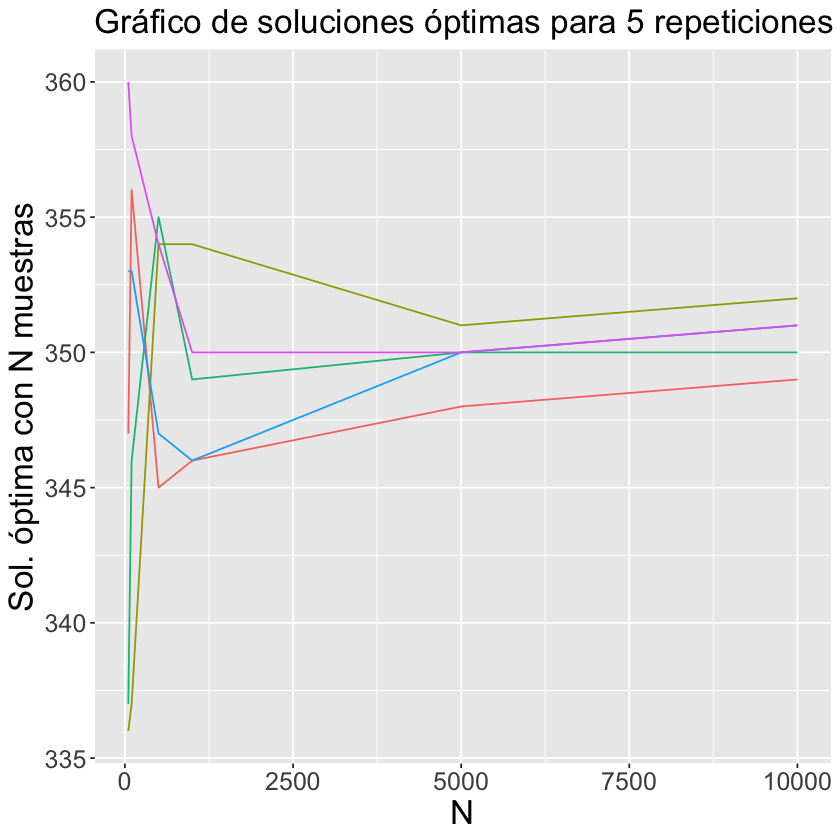

In [21]:

sol.df <- as.data.frame(sopt)
sol.df$N <- N
#sol.df
plot.sol <- sol.df %>% tidyr::gather("rep", "sol", 1:nrep) 
#plotdata   
ggplot(plot.sol, aes(N,sol,group=rep,color=rep)) +
       geom_line(show.legend = F)+
       mytheme+
       labs(y="Sol. óptima con N muestras",
            title=paste0("Gráfico de soluciones óptimas para ",nrep," repeticiones"))



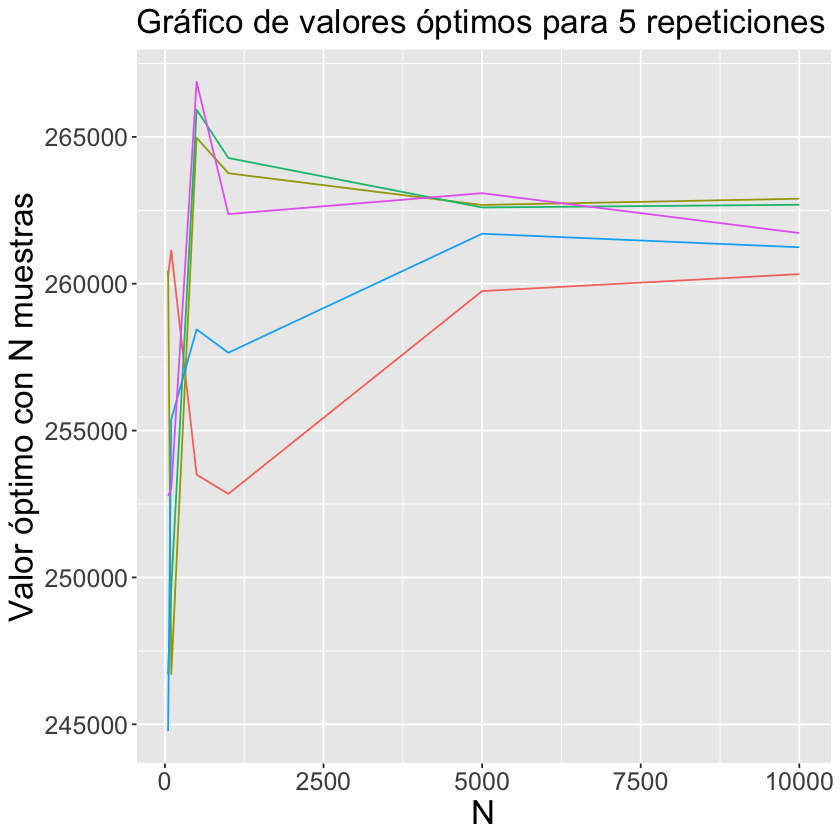

In [22]:
val.df <- as.data.frame(vopt)
val.df$N <- N
#sol.df
plot.val <- val.df %>% tidyr::gather("rep", "sol", 1:nrep) 
#plotdata   
ggplot(plot.val, aes(N,sol,group=rep,color=rep)) +
       geom_line(show.legend = F)+
       mytheme+
       labs(y="Valor óptimo con N muestras",
            title=paste0("Gráfico de valores óptimos para ",nrep," repeticiones"))



### La solución óptima parece converger a 350. Eso hace sentido.
### De hecho, el problema es una variación del **problema del vendedor de diarios**!
### Eso significa que podemos resolverlo **analíticamente** (recuerden el curso de IO...):

### $s^* = F^{-1}\left(\frac{c_u}{c_o+c_u}\right)$,
### donde
### $c_o=$ "overage cost" $=h$
### $c_u=$ "underage cost" $=q$
### $F$ es la función distribución acumulada de la demanda (en nuestro caso, Uniforme(100,400))


In [23]:
co <- h
cu <- q
ratio <- (cu/(co+cu))
s.opt <- qunif(ratio,100,400)
cat("sol. optima = ",s.opt)



sol. optima =  350

### Vemos que en este caso podríamos haber resuelto el problema directamente, sin simulación! Pero...

## El caso de 2 productos

### Calculemos los valores óptimos de cada producto individualmente:

In [24]:
r1 <- 300   #Precio de compra prod. 1
v1 <- 1500  #Precio de venta prod. 1
h1 <- r1     #Costo inventario prod. 1
q1 <- v1     #Costo quiebre de inventario prod. 1

r2 <- 1000   #Precio de compra prod. 2
v2 <- 3000  #Precio de venta prod. 2
h2 <- r2     #Costo inventario prod. 2
q2 <- v2     #Costo quiebre de inventario prod. 2

In [25]:
co1 <- h1
cu1 <- q1
ratio1 <- (cu/(co+cu))
s1.opt <- qunif(ratio1,100,400)
cat("Solución óptima producto 1 = ",s1.opt,"\n")

co2 <- h2
cu2 <- q2
ratio2 <- (cu2/(co2+cu2))
s2.opt <- qunif(ratio2,50,150)
cat("Solución óptima producto 2 = ",s2.opt)

Solución óptima producto 1 =  350 
Solución óptima producto 2 =  125

### ¿Qué pasa si la capacidad máxima de la bodega es de *300 botellas*?

### Aquí sí necesitamos resolver el problema utilizando simulación.

In [26]:
N <- 1000
Dp1 <- rdunif(N,400,100)
Dp2 <- rdunif(N,150,50)
Cap <- 300   #Capacidad de la bodega

result <- MILPModel() %>%
  add_variable(zo1[i], i=1:N, type = "continuous", lb = 0) %>%
  add_variable(zu1[i], i=1:N, type = "continuous", lb = 0)  %>%
  add_variable(s1, type = "continuous", lb = 0)  %>%
  add_constraint(zo1[i] - s1 >= -Dp1[i], i=1:N) %>%
  add_constraint(zu1[i] + s1 >= Dp1[i], i=1:N) %>%
  add_constraint(zu1[i] + s1 >= Dp1[i], i=1:N) %>%
  add_variable(zo2[i], i=1:N, type = "continuous", lb = 0) %>%
  add_variable(zu2[i], i=1:N, type = "continuous", lb = 0)  %>%
  add_variable(s2, type = "continuous", lb = 0)  %>%
  add_constraint(zo2[i] - s2 >= -Dp2[i], i=1:N) %>%
  add_constraint(zu2[i] + s2 >= Dp2[i], i=1:N) %>%
  add_constraint(zu2[i] + s2 >= Dp2[i], i=1:N) %>%
  add_constraint(s1+s2 <= Cap) %>%
  set_objective((1/N)*sum_expr(h1*zo1[i] + q1*zu1[i] + h2*zo2[i] + q2*zu2[i], i=1:N), "min") %>%
  solve_model(with_ROI(solver = "glpk")) 

In [27]:
cat(sprintf("Solución óptima producto 1 = %4.1f\n",get_solution(result, s1)))
cat(sprintf("Solución óptima producto 2 = %4.1f\n",get_solution(result, s2)))
cat(sprintf("Valor óptimo = %7.1f\n",(v1-r1)*mean(Dp1)+(v2-r2)*mean(Dp2)-objective_value(result)))



Solución óptima producto 1 = 199.0
Solución óptima producto 2 = 101.0
Valor óptimo = 344816.9
